Plotting script for deep O2 bias manuscript

2022_07_21 Seth Bushinsky - will try to piggy-back off code being writting by Veronica Tamsitt & the rest of the Argo BGC bias adjustment project (Bushinsky, Nachod, Fassbender, Williams)


In [64]:
import numpy as np
import pandas as pd
import xarray as xr
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, date, time
import time
from scipy import stats
import carbon_utils
import PyCO2SYS as pyco2
from scipy import interpolate

Function for converting date to year fraction (taken from stack overflow: https://stackoverflow.com/questions/6451655/how-to-convert-python-datetime-dates-to-decimal-float-years)

In [2]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [2]:
# read in a user-created text file to point to local directories to avoid having to change this every time 
# we update code
lines=[]
with open('path_file.txt') as f:
    lines = f.readlines()
    
count = 0
for line in lines:
    count += 1
    index = line.find("=")
    #print(f'line {count}: {line}')
    #print(index)
    #print(line[0:index])
    line = line.rstrip()
    if line[0:index].find("argo")>=0:
        argo_path=line[index+1:]
    elif line[0:index].find("liar")>=0:
        liar_dir=line[index+1:]
    elif line[0:index].find("matlab")>=0:
        matlab_dir=line[index+1:]
        
# Set the paths
output_dir = 'output/'
data_dir = 'data/'

In [3]:
output_dir_figs = 'figures_o2_bias/'

#check directories exist
if not os.path.isdir('figures_o2_bias'):
    os.mkdir('figures_o2_bias')

1. Read in all float Sprof files from argo path

In [34]:
argolist = []
for file in os.listdir(argo_path):
    if file.endswith('Sprof.nc'):
        argolist.append(file)

last = 0

2. For each file, find all profiles with valid O2 data, save out lat/lon/date into an array

In [35]:
#wmo_list = list()
for n in range(last, len(argolist)):
    print(f' {n}' ' File: ' + argolist[n]) 

    #n = 0
    argo_n = xr.load_dataset(argo_path+argolist[n])
    argo_n = argo_n.set_coords(('PRES_ADJUSTED','LATITUDE','LONGITUDE','JULD'))
    
    var_list = list(argo_n.data_vars)
    if "DOXY_ADJUSTED" not in var_list:
        print('Skipping')
        continue
            
    doxy_trimmed = argo_n.DOXY_ADJUSTED.where(~np.isnan(argo_n.DOXY_ADJUSTED), drop=True)
    wmo_n = argo_n.PLATFORM_NUMBER.values.astype(int)[0]

    prof_loc = xr.Dataset()
    prof_loc['wmo']=(['N_PROF'],np.repeat(wmo_n,len(doxy_trimmed)))

    prof_loc['LATITUDE'] = (['N_PROF'], doxy_trimmed.LATITUDE.data)
    prof_loc['LONGITUDE'] = (['N_PROF'], doxy_trimmed.LONGITUDE.data)
    prof_loc['juld'] = (['N_PROF'],doxy_trimmed.JULD.data)
    #prof_loc['profile'] = (['N_PROF'],doxy_trimmed.CYCLE_NUMBER.data)
    #argo_n
    # append all files into one long xarray
    if n == 0:
        argo_all = prof_loc
    else:
        argo_all = xr.concat([argo_all,prof_loc], 'N_PROF')

    last = n + 1
argo_all

 0 File: 1901378_Sprof.nc
 1 File: 1901379_Sprof.nc
 2 File: 5901315_Sprof.nc
 3 File: 6901898_Sprof.nc
 4 File: 6901899_Sprof.nc
 5 File: 5901314_Sprof.nc
 6 File: 6903768_Sprof.nc
 7 File: 2900737_Sprof.nc
 8 File: 5904687_Sprof.nc
 9 File: 3900348_Sprof.nc
 10 File: 2900736_Sprof.nc
 11 File: 5904686_Sprof.nc
 12 File: 4901806_Sprof.nc
 13 File: 6901592_Sprof.nc
 14 File: 6903805_Sprof.nc
 15 File: 5905080_Sprof.nc
 16 File: 6903804_Sprof.nc
 17 File: 6901593_Sprof.nc
 18 File: 5904473_Sprof.nc
 19 File: 5904472_Sprof.nc
 20 File: 3900714_Sprof.nc
 21 File: 6901766_Sprof.nc
 22 File: 6901767_Sprof.nc
 23 File: 3900715_Sprof.nc
 24 File: 6903153_Sprof.nc
 25 File: 3902121_Sprof.nc
 26 File: 3902120_Sprof.nc
 27 File: 6903152_Sprof.nc
 28 File: 5904127_Sprof.nc
 29 File: 5906246_Sprof.nc
 30 File: 5906020_Sprof.nc
 31 File: 5906021_Sprof.nc
 32 File: 5904126_Sprof.nc
 33 File: 5906247_Sprof.nc
 34 File: 2901178_Sprof.nc
 35 File: 5906307_Sprof.nc
 36 File: 5902109_Sprof.nc
 37 File: 5

KeyboardInterrupt: 

Plotting

In [ ]:
# plotting all data
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
plt.plot(argo_all.LONGITUDE, argo_all.LATITUDE, linestyle='none', marker='.', markersize=1)
plt.show()

In [ ]:
# Average data by wmo. Longitude is currently incorrectly averaged, which is fixed below
argo_wmo = argo_all.groupby('wmo').mean()

avg_date = argo_all.juld.astype('int64').groupby(argo_all['wmo']).mean().astype('datetime64[ns]')

# calculate the year fraction for plotting
avg_date_dec_year = []
for i in avg_date.values:
    x = pd.Timestamp(i)
    y = toYearFraction(x)
    avg_date_dec_year.append(y)

In [ ]:
for wmo in argo_wmo.wmo:
    temp_LONGITUDE = argo_all.LONGITUDE.where(argo_all.wmo==wmo, drop=True)
    if (np.max(temp_LONGITUDE) - np.min(temp_LONGITUDE))>300:
        print('YES')
        new_mean = np.mean(xr.where(temp_LONGITUDE>=0, temp_LONGITUDE, temp_LONGITUDE+360))
        if new_mean>180:
            new_mean = new_mean-360
            old_mean = argo_wmo.LONGITUDE.where(argo_wmo.wmo==wmo, drop=True)

        #print('old mean: '  + str(old_mean.values))
        #print('new mean: '  + str(new_mean.values))

        # put new LONGITUDE mean back into argo_wmo
        argo_wmo['LONGITUDE'] = argo_wmo.LONGITUDE.where(argo_wmo.wmo!=wmo, new_mean)
        #updated_mean = argo_wmo.LONGITUDE.where(argo_wmo.wmo==wmo, drop=True)

        #print('new mean: '  + str(updated_mean.values))

        #new_mean
    #else:
        #print('NO')

In [ ]:
# Figure 1

fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
sct = plt.scatter(x=argo_wmo.LONGITUDE, 
            y=argo_wmo.LATITUDE, 
            c=avg_date_dec_year,cmap='turbo',s=10)
cbar = plt.colorbar(sct, fraction=.08, pad = 0.04, shrink=0.5)
cbar.set_label('Year', labelpad=15, fontsize=14)
plt.savefig(output_dir_figs+ 'Fig_1_O2_float_map_date.png')
plt.show()


Alternate version of Figure 1: gridded observational density

NameError: name 'argo_all' is not defined

/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


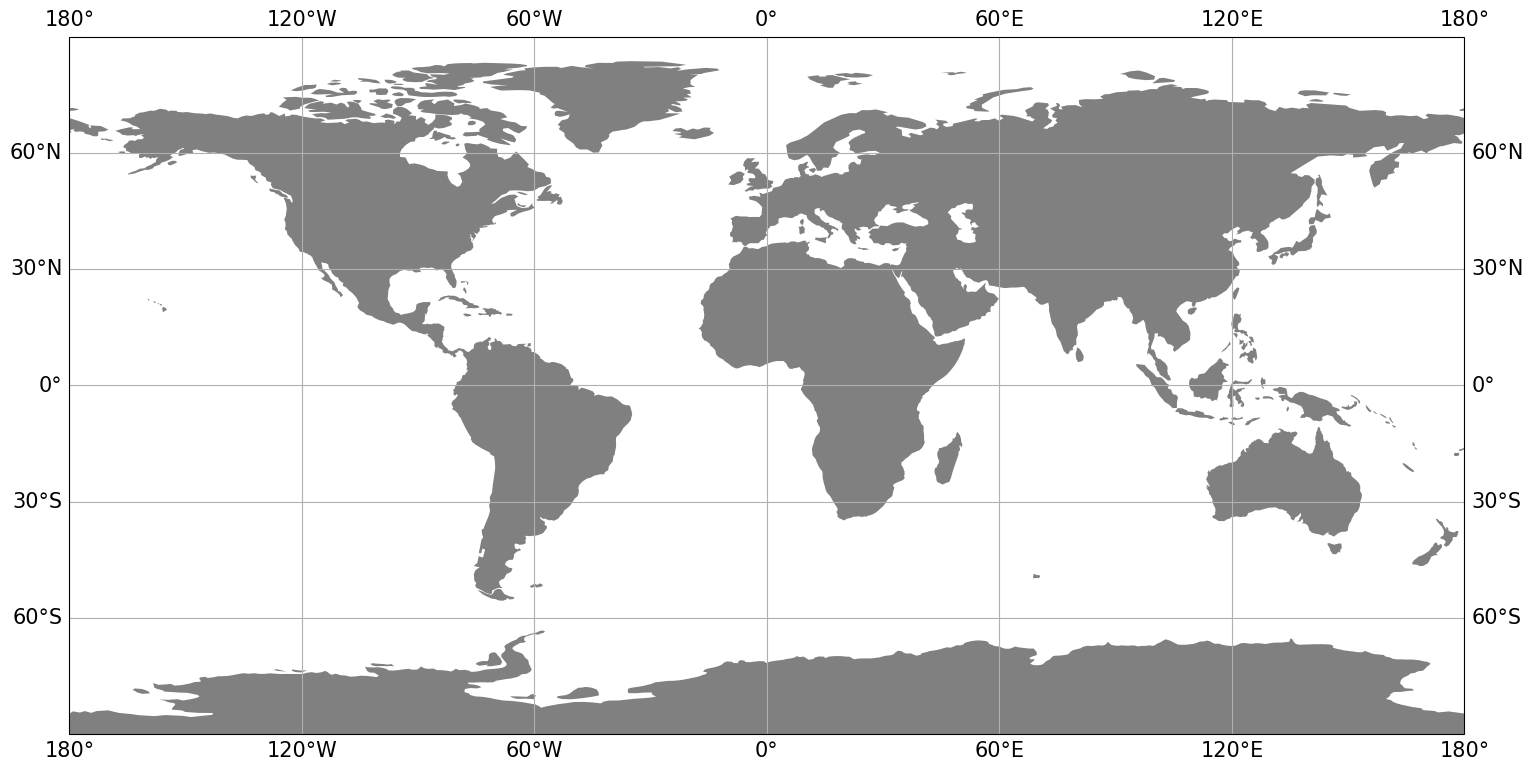

In [7]:
# Gridded density plot taken from J. Lilly's Distributional-Analysis code: http://www.jmlilly.net/course/labs/html/DistributionalAnalysis-Python.html
figsize=np.array([18, 12]);
projection=ccrs.PlateCarree();

cmap = plt.cm.get_cmap("Spectral_r", 64)

#for future reference, define a function to set up our map
def map_setup(figsize,projection):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=projection)
    ax.add_feature(cfeature.LAND, facecolor='grey')
    gl = ax.gridlines(draw_labels=True)  
    gl
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    return fig, ax 

fig, ax = map_setup(figsize,projection) 

dlatlon = 1
lonbins = np.arange(-180, 180, dlatlon)
latbins = np.arange(-80, 80, dlatlon)

hist = stats.binned_statistic_2d(argo_all.LATITUDE, argo_all.LONGITUDE, None, bins=[latbins, lonbins], statistic="count")
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
hist.statistic

image = plt.pcolormesh(lonbins, latbins, hist.statistic, cmap=cmap, shading="flat", transform=ccrs.PlateCarree()) 
plt.clim(0, 100) 

cbar = fig.colorbar(image, ax=ax, orientation='horizontal', fraction=0.1, aspect=40, pad=0.08)
               
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label='Number of Observations', size=20)
plt.savefig(output_dir_figs+ 'Fig_1v2_Argo_O2_Sampling_Density.png')

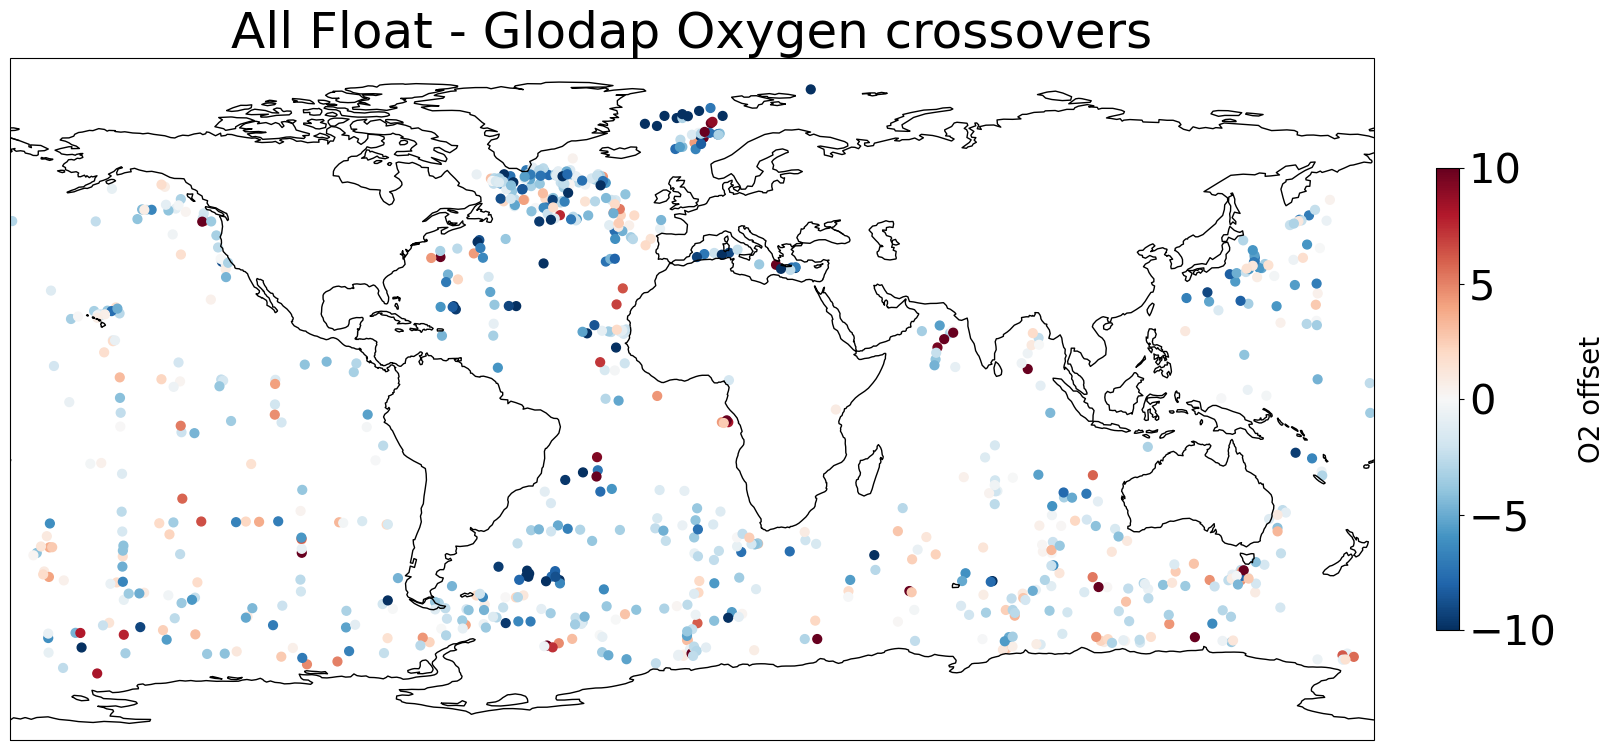

In [320]:
# Maps of offsets - need to fix longitude issue for this plot

fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
sct = plt.scatter(glodap_offsets_mean.main_float_longitude, glodap_offsets_mean.main_float_latitude,
                c=glodap_offsets_mean.DOXY_ADJUSTED_offset, cmap='RdBu_r',s=40,vmin=-10,vmax=10)
cbar = plt.colorbar(sct, fraction=.08, pad = 0.04, shrink=0.5)
cbar.set_label('O2 offset', labelpad=15, fontsize=20)
plt.title('All Float - Glodap Oxygen crossovers')
plt.rcParams.update({'font.size': 30})

plt.savefig(output_dir_figs+ 'All Float - Glodap Oxygen crossovers.png')
plt.show()

Figure 3. Histograms showing any bias in bgc parameters from crossovers with glodap


In [4]:
glodap_offsets_mean = xr.load_dataset(output_dir+'glodap_offsets_floatmean_withcalibration.nc')
glodap_offsets_p = glodap_offsets_mean.to_dataframe()

In [7]:
parameter_a = 'o2_calib_air_group'
parameter_b = 'pH_group'
offsets_g = glodap_offsets_p.groupby(parameter_a)

In [8]:
offsets_pH = glodap_offsets_p.groupby([parameter_a, parameter_b])

In [ ]:

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
nmean = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset'].mean(), decimals=2)
nmedian = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset'].median(), decimals=2)
ncount = glodap_offsets_mean['DOXY_ADJUSTED_offset'].count()
    
plt.hist(glodap_offsets_mean['DOXY_ADJUSTED_offset'], 
         bins=np.linspace(-170, 170, 61),label='mean='+str(nmean.values) + ' median='+str(nmedian.values) + 
         ', n='+str(ncount.values)) # ,label=str(n)
#print(np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset'].median().values, decimals=2))
plt.grid()
plt.title('All float crossovers')
plt.xlabel(r'DOXY Offset ( $\mu$mol kg$^{-1}$)')
plt.legend()

plt.subplot(2,2,3)
plt.title('All floats, $\pm$ 20 $\mu$mol kg$^{-1}$ range')
plt.hist(glodap_offsets_mean['DOXY_ADJUSTED_offset'], 
         bins=np.linspace(-20, 20, 61),label='median='+str(nmedian.values) + 
         ', n='+str(ncount.values)) # ,label=str(n)
plt.grid()
plt.xlabel(r'DOXY Offset ( $\mu$mol kg$^{-1}$)')

plt.subplot(2,2,2)

for n, group in offsets_g:
    print(n)
    nmean = np.around(group['DOXY_ADJUSTED_offset'].mean(), decimals=2)
    nmedian = np.around(group['DOXY_ADJUSTED_offset'].median(), decimals=2)
    ncount = group['DOXY_ADJUSTED_offset'].count()

    plt.hist(group['DOXY_ADJUSTED_offset'], bins=np.linspace(-20, 20, 61),
             alpha=0.3,label=str(n)+' \nmed.='+str(nmedian) + 
         ', n='+str(ncount))
    plt.grid()
    plt.title('Grouped by air calibration')

    plt.xlabel(r'DOXY Offset ( $\mu$mol kg$^{-1}$)')
    plt.legend()

plt.subplot(2,2,4)

for n, group in offsets_pH:
    if n[1] == 'no pH' or n[0] == 'no cal/bad':
        continue
    print(n)
    nmean = np.around(group['DOXY_ADJUSTED_offset'].mean(), decimals=2)
    nmedian = np.around(group['DOXY_ADJUSTED_offset'].median(), decimals=2)
    ncount = group['DOXY_ADJUSTED_offset'].count()

    plt.hist(group['DOXY_ADJUSTED_offset'], bins=np.linspace(-20, 20, 61),
             alpha=0.3,label=str(n)+' \nmed.='+str(nmedian) + 
         ', n='+str(ncount))
    plt.title('pH floats only')
    plt.grid()

    plt.xlabel(r'DOXY Offset ( $\mu$mol kg$^{-1}$)')
    plt.legend()
    
plt.tight_layout()

plt.savefig(output_dir_figs + 'Glodap_offsets_doxy_all_v2.png')


# apparently need to filter out and understand some very large outliers

Calculating pH impact of oxygen bias - maybe supplemental figure

In [310]:
glodap_offsets_mean

<xarray.Dataset>
Dimensions:                       (main_float_wmo: 852)
Coordinates:
  * main_float_wmo                (main_float_wmo) int64 1900722 ... 7900585
Data variables: (12/45)
    PRES_ADJUSTED_offset          (main_float_wmo) float64 -13.62 ... 103.9
    PRES_ADJUSTED_glodap          (main_float_wmo) float64 1.744e+03 ... 1.76...
    PRES_ADJUSTED_float           (main_float_wmo) float64 1.731e+03 ... 1.86...
    TEMP_ADJUSTED_offset          (main_float_wmo) float64 -0.005812 ... 0.00...
    TEMP_ADJUSTED_glodap          (main_float_wmo) float64 2.759 4.168 ... 3.501
    TEMP_ADJUSTED_float           (main_float_wmo) float64 2.753 4.18 ... 3.503
    ...                            ...
    pH_sensor                     (main_float_wmo) object 'none' ... 'none'
    nitrate_group                 (main_float_wmo) object 'no nitrate' ... 'n...
    nitrate_sensor                (main_float_wmo) object 'none' ... 'none'
    DOXY_group                    (main_float_wmo) object 'DOXY' ... 'DOXY'
    DOXY_sensor                   (main_float_wmo) object 'AANDERAA_OPTODE_38...
    ice_group                     (main_float_wmo) object 'no ice' ... 'no ice'

In [5]:
argo_interpolated = xr.load_dataset(data_dir + 'argo_interp_temp.nc')
argo_interp_wmo = argo_interpolated.groupby('wmo')

In [185]:
LIPHR_path = liar_dir


float_wmo_list = glodap_offsets_p.index.values
MeasIDVec = [1, 7, 3, 6]
last = 0

for n in range(0, float_wmo_list.shape[0]):
    wmo_n = float_wmo_list[n]
    if glodap_offsets_p.pH_group[glodap_offsets_p.index==wmo_n].values=='no pH':
        continue
    print('N: ' + str(n) + ' ' + str(wmo_n) + ' started')
    
    argo_derived_n = xr.load_dataset(argo_path+ 'derived/' + str(wmo_n) + '_derived.nc')

    nprof = argo_derived_n.LATITUDE.shape[0]
    if nprof==1: # if there is only one profile, probably don't want to trust any offset
        continue

    # initialize coordinate and measurement arrays
    Coordinates_all = np.empty([nprof, 3],dtype=float)
    Coordinates_all[:] = np.nan
       
    Measurements_all = np.empty([nprof, 4],dtype=float)
    Measurements_all[:] = np.nan
    for p in range(nprof):
        # load interpolated argo_data so that 1500 m data is present 
        argo_profile = argo_interp_wmo[wmo_n].isel(N_PROF=p)
        argo_profile.load()
        data_1500 = argo_profile.where(argo_profile.PRES_ADJUSTED==1500, drop=True) 
        if data_1500.LATITUDE.size==0:
            continue
        #index_1500 = argo_profile.PRES_ADJUSTED==1500 #argo_wmo[wmo_n].PRES_ADJUSTED[p,:]==1500

        #argo_wmo[5904659].PSAL_ADJUSTED[0,index_1500]
        Coordinates_all[p,:] = np.stack((data_1500.LONGITUDE.values, 
                            data_1500.LATITUDE.values, 
                            data_1500.PRES_ADJUSTED.values),
                            axis=1)
        Measurements_all[p,:] = np.stack((data_1500.PSAL_ADJUSTED.values, 
                             data_1500.TEMP_ADJUSTED.values, 
                             data_1500.NITRATE_ADJUSTED.values, 
                             data_1500.DOXY_ADJUSTED.values),
                             axis=1)
    
    # calculate LIPHR pH for all profiles
    test_pH = carbon_utils.LIPHR_matlab(LIPHR_path,
                                    Coordinates_all.tolist(),
                                    Measurements_all.tolist(),
                                    MeasIDVec, 
                                    OAAdjustTF = False)  

    # create a second Measurements array that adjusts oxygen according to the mean glodap bias. Subtract the offset to correct it properly
    Measurements_o2_offset = np.concatenate(([Measurements_all[:,0]], 
                                  [Measurements_all[:,1]],
                                  [Measurements_all[:,2]],
                                  [Measurements_all[:,3]] - 
                                  glodap_offsets_p.DOXY_ADJUSTED_offset[glodap_offsets_p.index==wmo_n].values))

    Measurements_o2_offset = np.transpose(Measurements_o2_offset)
    # calculate LIPHR pH for all profiles
    new_pH = carbon_utils.LIPHR_matlab(LIPHR_path,
                                    Coordinates_all.tolist(),
                                    Measurements_o2_offset.tolist(),
                                    MeasIDVec, 
                                    OAAdjustTF = False)  
    argo_derived_n['pH_orig_LIPHR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
    argo_derived_n.pH_orig_LIPHR[:] = test_pH[:,0]

    argo_derived_n['pH_O2_ADJUST_LIPHR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
    argo_derived_n.pH_O2_ADJUST_LIPHR[:] = new_pH[:,0]
    # difference between pH_O2_orig_LIPHR and PH_IN_SITU_TOTAL_ADJUSTED- should that average 0? 
    # Impact of O2 can be seen in the test_pH minus new_pH average 
    
    argo_derived_n['PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET'] = \
        argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(new_pH - test_pH)
    
    argo_derived_n.to_netcdf(argo_path+ 'derived/' + str(wmo_n) + '_derived_2.nc')
    print(str(wmo_n)+ ' finished')

    last=n

N: 33 1902303 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desi

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3444/2668441288.py:76: RuntimeWarning: Mean of empty slice
  argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(new_pH - test_pH)


By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3444/2668441288.py:76: RuntimeWarning: Mean of empty slice
  argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(new_pH - test_pH)


By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3444/2668441288.py:76: RuntimeWarning: Mean of empty slice
  argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(new_pH - test_pH)


By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3444/2668441288.py:76: RuntimeWarning: Mean of empty slice
  argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(new_pH - test_pH)


5906529 finished
N: 674 5906623 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired

Load all derived_2.nc files, read in offset and pH impacts, plot 

In [223]:
derivedlist = []
for file in os.listdir(argo_path + 'derived/'):
    if file.endswith('derived_2.nc'):
        derivedlist.append(file)

#last = 0

In [187]:
# open derivedlist files, check if there are new pH values, then collect o2 offsets and average pH impact:
pH_impact = list()
o2_offset = list()
o2_1500 = list()
temp_1500 = list()
sal_1500 = list()
no3_1500 = list()



 0 File: 6903575_derived_2.nc
 1 File: 5906207_derived_2.nc
 2 File: 5905102_derived_2.nc
 3 File: 5905075_derived_2.nc
 4 File: 5905072_derived_2.nc
 5 File: 5904186_derived_2.nc
 6 File: 5903893_derived_2.nc
 7 File: 5906215_derived_2.nc
 8 File: 5906441_derived_2.nc
 9 File: 5906247_derived_2.nc
 10 File: 5906212_derived_2.nc
 11 File: 2903700_derived_2.nc
 12 File: 2903670_derived_2.nc
 13 File: 5906306_derived_2.nc
 14 File: 5906488_derived_2.nc
 15 File: 5904693_derived_2.nc
 16 File: 5906500_derived_2.nc
 17 File: 5906224_derived_2.nc


/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/PyCO2SYS/buffers/__init__.py:40: RuntimeWarning: divide by zero encountered in divide
  gammaTA = dTA_dPH__TC / dlnCO2_dPH__TC


 18 File: 5906301_derived_2.nc
 19 File: 5904694_derived_2.nc
 20 File: 5906507_derived_2.nc
 21 File: 6903551_derived_2.nc
 22 File: 4903365_derived_2.nc
 23 File: 5904474_derived_2.nc
 24 File: 5904473_derived_2.nc


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3444/175547450.py:21: RuntimeWarning: Mean of empty slice
  mean_pH_impact_n = np.nanmean(argo_n['pH_O2_ADJUST_LIPHR'] - argo_n['pH_orig_LIPHR'])


 25 File: 2903614_derived_2.nc
 26 File: 5906236_derived_2.nc
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negativ

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3444/175547450.py:21: RuntimeWarning: Mean of empty slice
  mean_pH_impact_n = np.nanmean(argo_n['pH_O2_ADJUST_LIPHR'] - argo_n['pH_orig_LIPHR'])


 52 File: 5906315_derived_2.nc
 53 File: 5906340_derived_2.nc
 54 File: 5905972_derived_2.nc
 55 File: 5906237_derived_2.nc
 56 File: 5905135_derived_2.nc
 57 File: 5905132_derived_2.nc
 58 File: 6903550_derived_2.nc
 59 File: 5905998_derived_2.nc
 60 File: 5906222_derived_2.nc
 61 File: 5906300_derived_2.nc
 62 File: 5904695_derived_2.nc
 63 File: 5906501_derived_2.nc
 64 File: 5906307_derived_2.nc
 65 File: 5906489_derived_2.nc
 66 File: 5906476_derived_2.nc
 67 File: 5904472_derived_2.nc
 68 File: 5905367_derived_2.nc
 69 File: 5905995_derived_2.nc
 70 File: 5904660_derived_2.nc
 71 File: 5905992_derived_2.nc
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.


/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/PyCO2SYS/buffers/__init__.py:40: RuntimeWarning: divide by zero encountered in divide
  gammaTA = dTA_dPH__TC / dlnCO2_dPH__TC


Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
 72 File: 5906030_derived_2.nc
 73 File: 5906636_derived_2.nc
 74 File: 5906297_derived_2.nc
 75 File: 5906491_derived_2.nc
 76 File: 5904675_derived_2.nc
 77 File: 5905375_derived_2.nc
 78 File: 5905980_derived_2.nc
 79 File: 5906318_derived_2.nc
 80 File: 5904672_derived_2.nc
 81 File: 5905372_derived_2.nc
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather th

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3444/175547450.py:21: RuntimeWarning: Mean of empty slice
  mean_pH_impact_n = np.nanmean(argo_n['pH_O2_ADJUST_LIPHR'] - argo_n['pH_orig_LIPHR'])


 133 File: 5904767_derived_2.nc
 134 File: 5905078_derived_2.nc
 135 File: 5906040_derived_2.nc
 136 File: 5905080_derived_2.nc
 137 File: 5904856_derived_2.nc
 138 File: 5906026_derived_2.nc
 139 File: 5904469_derived_2.nc
 140 File: 5906294_derived_2.nc
 141 File: 5904676_derived_2.nc
 142 File: 5905376_derived_2.nc
 143 File: 5906492_derived_2.nc
 144 File: 5906438_derived_2.nc
 145 File: 5905983_derived_2.nc
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative D

/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/PyCO2SYS/buffers/__init__.py:40: RuntimeWarning: divide by zero encountered in divide
  gammaTA = dTA_dPH__TC / dlnCO2_dPH__TC


 150 File: 5906033_derived_2.nc
 151 File: 5906635_derived_2.nc
 152 File: 5905996_derived_2.nc
 153 File: 5905969_derived_2.nc
 154 File: 5904663_derived_2.nc
 155 File: 5906487_derived_2.nc
 156 File: 5906309_derived_2.nc
 157 File: 5905991_derived_2.nc
 158 File: 5906005_derived_2.nc
 159 File: 5904396_derived_2.nc
 160 File: 5904846_derived_2.nc
 161 File: 5906002_derived_2.nc
 162 File: 5904841_derived_2.nc
 163 File: 5904124_derived_2.nc
 164 File: 5904655_derived_2.nc


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3444/175547450.py:21: RuntimeWarning: Mean of empty slice
  mean_pH_impact_n = np.nanmean(argo_n['pH_O2_ADJUST_LIPHR'] - argo_n['pH_orig_LIPHR'])


 165 File: 5905501_derived_2.nc
 166 File: 5904854_derived_2.nc
 167 File: 5906042_derived_2.nc
 168 File: 5906045_derived_2.nc
 169 File: 5904765_derived_2.nc
 170 File: 5906208_derived_2.nc
 171 File: 2903648_derived_2.nc
 172 File: 5906032_derived_2.nc
 173 File: 5906035_derived_2.nc
 174 File: 5906486_derived_2.nc
 175 File: 5904662_derived_2.nc
 176 File: 5905997_derived_2.nc
 177 File: 5905441_derived_2.nc
 178 File: 5904468_derived_2.nc
 179 File: 5906238_derived_2.nc
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high giv

/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/PyCO2SYS/buffers/__init__.py:40: RuntimeWarning: divide by zero encountered in divide
  gammaTA = dTA_dPH__TC / dlnCO2_dPH__TC


Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
 188 File: 5906043_derived_2.nc
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH va

/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/PyCO2SYS/buffers/__init__.py:40: RuntimeWarning: divide by zero encountered in divide
  gammaTA = dTA_dPH__TC / dlnCO2_dPH__TC


 202 File: 3901667_derived_2.nc
 203 File: 1902304_derived_2.nc
 204 File: 5904185_derived_2.nc
 205 File: 5906243_derived_2.nc
 206 File: 5906216_derived_2.nc
 207 File: 5904659_derived_2.nc
 208 File: 5906244_derived_2.nc
 209 File: 5906211_derived_2.nc
 210 File: 5905101_derived_2.nc
 211 File: 2903666_derived_2.nc
 212 File: 5904982_derived_2.nc
 213 File: 5905076_derived_2.nc
 214 File: 5905023_derived_2.nc
 215 File: 5904858_derived_2.nc


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3444/175547450.py:31: RuntimeWarning: Mean of empty slice
  o2_1500.append(np.nanmean(second_filt.DOXY_ADJUSTED))


 216 File: 5905071_derived_2.nc
 217 File: 5906204_derived_2.nc
 218 File: 5906527_derived_2.nc
 219 File: 5905130_derived_2.nc
 220 File: 2903657_derived_2.nc
 221 File: 5905970_derived_2.nc
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather t

/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/PyCO2SYS/buffers/__init__.py:40: RuntimeWarning: divide by zero encountered in divide
  gammaTA = dTA_dPH__TC / dlnCO2_dPH__TC


Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
 236 File: 5906227_derived_2.nc
 237 File: 5906302_derived_2.nc
 238 File: 5905368_derived_2.nc


/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/PyCO2SYS/buffers/__init__.py:40: RuntimeWarning: divide by zero encountered in divide
  gammaTA = dTA_dPH__TC / dlnCO2_dPH__TC


 239 File: 5906220_derived_2.nc
 240 File: 5904984_derived_2.nc
 241 File: 5905107_derived_2.nc
 242 File: 5904859_derived_2.nc
 243 File: 5905077_derived_2.nc
 244 File: 5904983_derived_2.nc
 245 File: 5906205_derived_2.nc


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3444/175547450.py:31: RuntimeWarning: Mean of empty slice
  o2_1500.append(np.nanmean(second_filt.DOXY_ADJUSTED))


 246 File: 5906250_derived_2.nc
 247 File: 5906008_derived_2.nc
 248 File: 4903273_derived_2.nc
 249 File: 5905636_derived_2.nc
 250 File: 4903274_derived_2.nc
 251 File: 5906210_derived_2.nc
 252 File: 5906245_derived_2.nc
 253 File: 5904658_derived_2.nc
 254 File: 5906217_derived_2.nc
 255 File: 5904184_derived_2.nc
 256 File: 5904471_derived_2.nc
 257 File: 5906039_derived_2.nc
 258 File: 5904476_derived_2.nc
 259 File: 5906221_derived_2.nc
 260 File: 5906303_derived_2.nc
 261 File: 5906472_derived_2.nc
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input p

In [230]:

for n in range(201, 202):#, len(derivedlist)):
        
        print(f' {n}' ' File: ' + derivedlist[n]) 
        argo_n = xr.load_dataset(argo_path + 'derived/' + derivedlist[n])
        var_list = list(argo_n.data_vars)
        wmo_n = argo_n['wmo']

        if "pH_O2_ADJUST_LIPHR" not in var_list:
                print('Skipping')
                continue

        mean_pH_impact_n = np.nanmean(argo_n['pH_O2_ADJUST_LIPHR'] - argo_n['pH_orig_LIPHR'])
        pH_impact.append(mean_pH_impact_n)

        o2_offset_n = glodap_offsets_p.DOXY_ADJUSTED_offset[glodap_offsets_p.index==wmo_n.values].values
        o2_offset.append(o2_offset_n)

        # find 1500m data and save out to explore sensitivity of pH to O2
        first_filt = argo_n.where(argo_n.PRES_ADJUSTED>1450, drop=True)
        second_filt = first_filt.where(first_filt.PRES_ADJUSTED<1550, drop=True)
        
        o2_1500.append(np.nanmean(second_filt.DOXY_ADJUSTED))
        temp_1500.append(np.nanmean(second_filt.TEMP_ADJUSTED))
        sal_1500.append(np.nanmean(second_filt.PSAL_ADJUSTED))

        if 'TALK_LIAR' not in argo_n.keys():
                continue

        if 'NITRATE_ADJUSTED' in argo_n.keys():
                SI = argo_n.NITRATE_ADJUSTED*2.5
                SI.where(~np.isnan(SI), 0)
                PO4 = argo_n.NITRATE_ADJUSTED/16
                PO4.where(~np.isnan(PO4),0)
        else:
                SI = np.zeros((argo_n.PH_IN_SITU_TOTAL_ADJUSTED.shape))
                PO4 = np.zeros((argo_n.PH_IN_SITU_TOTAL_ADJUSTED.shape))

        # replace any negative pH values with nans:
        argo_n['PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET'] = \
                argo_n.PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET.where(argo_n.PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET>0)

        results = pyco2.sys(
                par1=argo_n.TALK_LIAR, 
                par2=argo_n.PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET,
                par1_type=1,
                par2_type=3,
                temperature=argo_n.TEMP_ADJUSTED, 
                pressure=argo_n.PRES_ADJUSTED, 
                salinity=argo_n.PSAL_ADJUSTED, 
                temperature_out=argo_n.TEMP_ADJUSTED, #fixed 25C temperature
                pressure_out=argo_n.PRES_ADJUSTED,
                total_silicate=SI,
                total_phosphate=PO4,
                opt_pH_scale = 1, #total
                opt_k_carbonic=10, #Lueker et al. 2000
                opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
                opt_total_borate=2, # Lee et al. 2010
                opt_k_fluoride=2, # Perez and Fraga 1987
                opt_buffers_mode=1,
        )
        argo_n['pCO2_pH_TOTAL_ADJUST_O2_IMPACT'] = (['N_PROF','N_LEVELS'],results['pCO2'])  

        # replace any negative pH values with nans:
        argo_n['PH_IN_SITU_TOTAL_ADJUSTED'] = \
                argo_n.PH_IN_SITU_TOTAL_ADJUSTED.where(argo_n.PH_IN_SITU_TOTAL_ADJUSTED>0)

        results = pyco2.sys(
                par1=argo_n.TALK_LIAR, 
                par2=argo_n.PH_IN_SITU_TOTAL_ADJUSTED,
                par1_type=1,
                par2_type=3,
                temperature=argo_n.TEMP_ADJUSTED, 
                pressure=argo_n.PRES_ADJUSTED, 
                salinity=argo_n.PSAL_ADJUSTED, 
                temperature_out=argo_n.TEMP_ADJUSTED, #fixed 25C temperature
                pressure_out=argo_n.PRES_ADJUSTED,
                total_silicate=SI,
                total_phosphate=PO4,
                opt_pH_scale = 1, #total
                opt_k_carbonic=10, #Lueker et al. 2000
                opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
                opt_total_borate=2, # Lee et al. 2010
                opt_k_fluoride=2, # Perez and Fraga 1987
                opt_buffers_mode=1,
        )
        argo_n['pCO2_pH_no_bias_corr'] = (['N_PROF','N_LEVELS'],results['pCO2'])  

        # currently commented out, will add back in once pH_in_situ_corr is calculated / saved
        # argo_n['PH_IN_SITU_CORR_w_O2_ADJUST_OFFSET'] = \
        #         argo_n.pH_insitu_corr + np.nanmean(argo_n['pH_O2_ADJUST_LIPHR'] - argo_n['pH_orig_LIPHR'])

        # results = pyco2.sys(
        #                 par1=argo_n.TALK_LIAR, 
        #                 par2=argo_n.PH_IN_SITU_CORR_w_O2_ADJUST_OFFSET,
        #                 par1_type=1,
        #                 par2_type=3,
        #                 temperature=argo_n.TEMP_ADJUSTED, 
        #                 pressure=argo_n.PRES_ADJUSTED, 
        #                 salinity=argo_n.PSAL_ADJUSTED, 
        #                 temperature_out=argo_n.TEMP_ADJUSTED, #fixed 25C temperature
        #                 pressure_out=argo_n.PRES_ADJUSTED,
        #                 total_silicate=SI,
        #                 total_phosphate=PO4,
        #                 opt_pH_scale = 1, #total
        #                 opt_k_carbonic=10, #Lueker et al. 2000
        #                 opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
        #                 opt_total_borate=2, # Lee et al. 2010
        #                 opt_k_fluoride=2, # Perez and Fraga 1987
        #                 opt_buffers_mode=1,
        # )
        # argo_n['pCO2_pH_CORR_O2_IMPACT'] = (['N_PROF','N_LEVELS'],results['pCO2'])  

        argo_n.to_netcdf(argo_path+ 'derived/' + str(wmo_n.values) + '_derived_3.nc')

 201 File: 5905637_derived_2.nc


0.0021965164162252543

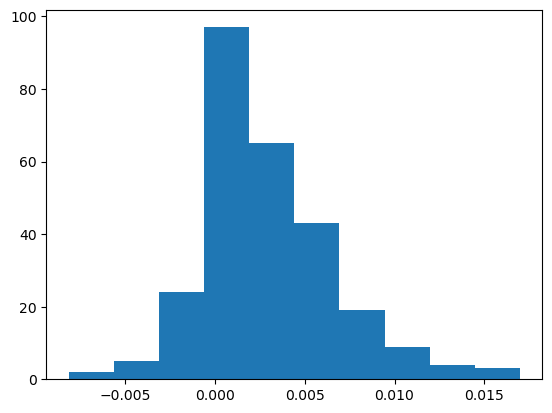

In [188]:
plt.hist(pH_impact)
np.nanmedian(pH_impact)

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3444/2076323682.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


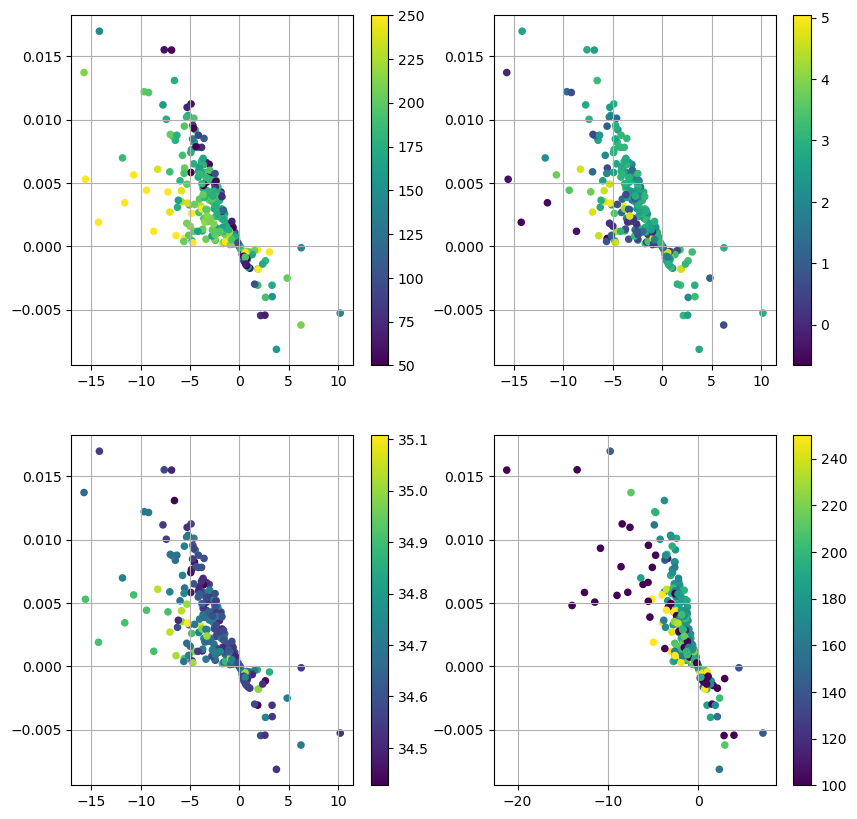

In [309]:
#fig,(ax1, ax2, ax3, ax4) = plt.subplots(figsize=(10,10), ncols=2, nrows=2)
fig = plt.subplots(figsize=(10,10))
plt.subplot(221)
pos = plt.scatter(o2_offset, pH_impact, 20, o2_1500, vmin=50, vmax=250)
plt.colorbar(pos)
plt.grid()

plt.subplot(222)
pos2 = plt.scatter(o2_offset, pH_impact, 20, temp_1500)
plt.colorbar(pos2)
plt.grid()

plt.subplot(223)
pos2 = plt.scatter(o2_offset, pH_impact, 20, sal_1500)
plt.colorbar(pos2)
plt.grid()

o2_array = np.array(o2_offset).reshape(1,-1)
o2_1500_array = np.array(o2_1500)
pH_impact_array = np.array(pH_impact)

percent_o2 = o2_array/o2_1500_array*100

plt.subplot(224)
pos = plt.scatter(percent_o2, pH_impact_array, 20, o2_1500_array, vmin=100, vmax=250)
plt.colorbar(pos)
plt.grid()

plt.savefig(output_dir_figs+ 'pH_impact vs_O2_Offset.png')


In [302]:
o2_array = np.array(o2_offset)
o2_1500_array = np.array(o2_1500)
o2_1500_array.shape

(277,)

In [304]:
o2_array_transpose = o2_array.reshape(1,-1)
o2_array_transpose.shape


SyntaxError: invalid syntax (903174375.py, line 1)

In [305]:

percent_o2 = o2_array_transpose/o2_1500_array*100
# o2_array.reshape()
percent_o2.shape


(1, 277)

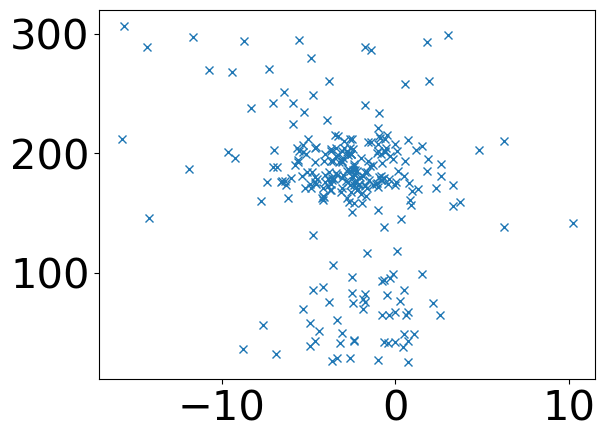

In [322]:
# need to redo this work with all glodap crossovers, not float averages
plt.plot(o2_offset, o2_1500, marker = 'x', linestyle='None')

In [6]:
# plotting pCO2 impacts for floats:
derivedlist = []
for file in os.listdir(argo_path + 'derived/'):
    if file.endswith('derived_3.nc'):
        derivedlist.append(file)
pCO2_impact = list()
o2_offset_3 = list()
last=0


In [15]:
derivedlist.index("1902382_derived_3.nc")

105

In [17]:
derivedlist[105]

'1902382_derived_3.nc'

 105 File: 1902382_derived_3.nc


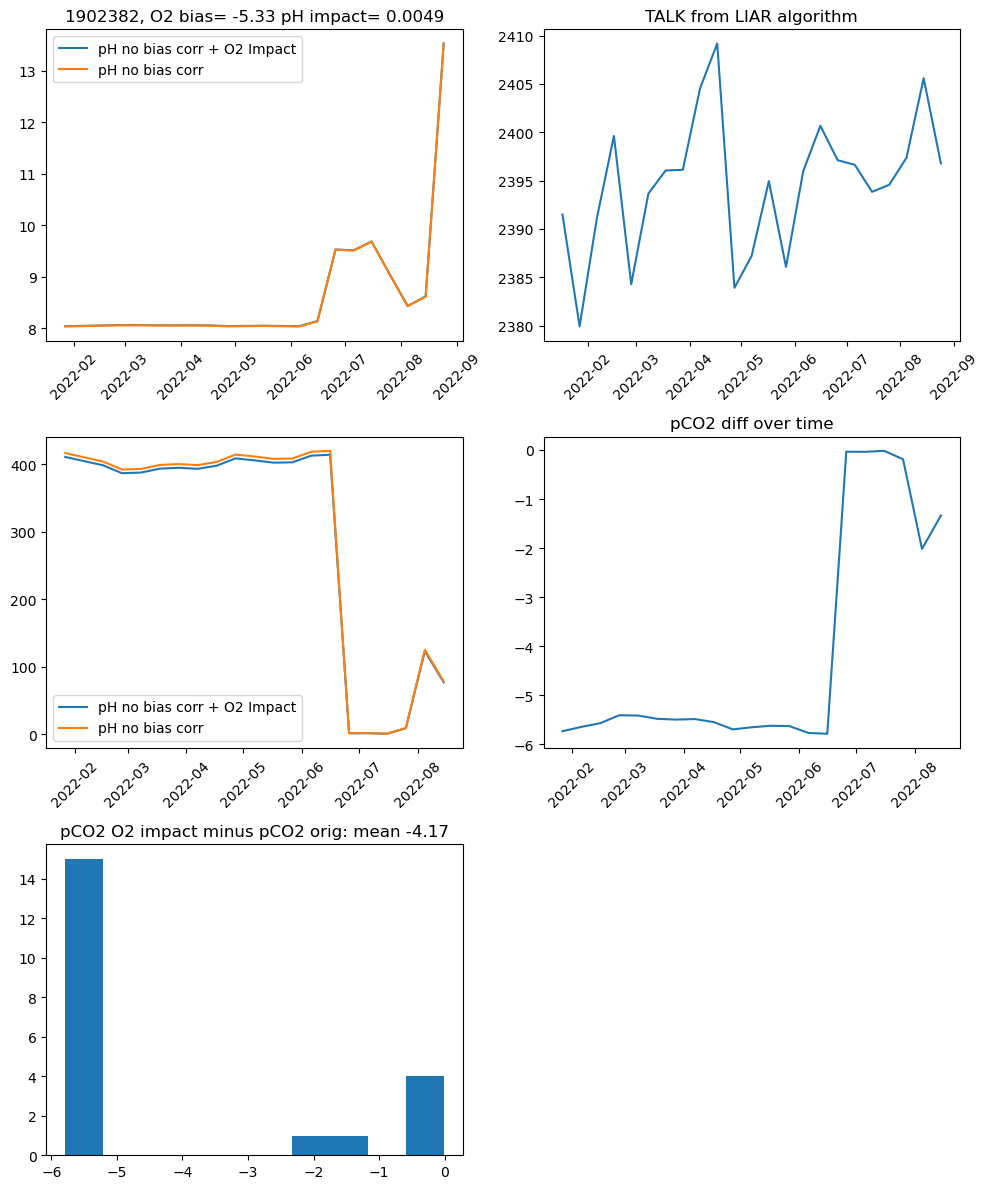

In [20]:
show_plot=True

for n in range(105, 106): #range(last, len(derivedlist)):

    print(f' {n}' ' File: ' + derivedlist[n]) 
    argo_n = xr.load_dataset(argo_path + 'derived/' + derivedlist[n])

    argo_n

    wmo_n = argo_n['wmo']

    mean_pH = np.nanmean(argo_n['pH_O2_ADJUST_LIPHR'] - argo_n['pH_orig_LIPHR'])
    o2_offset_n = glodap_offsets_p.DOXY_ADJUSTED_offset[glodap_offsets_p.index==wmo_n.values].values

    upper_25m = argo_n.where(argo_n.PRES_ADJUSTED<25, drop=False)
    #upper_25m.pCO2_pH_corr.mean(dim='N_LEVELS')

    pCO2_diff = upper_25m.pCO2_pH_TOTAL_ADJUST_O2_IMPACT.mean(dim='N_LEVELS') - upper_25m.pCO2_pH_no_bias_corr.mean(dim='N_LEVELS')
    pCO2_impact.append(np.mean(pCO2_diff).data)
    o2_offset_3.append(o2_offset_n)


    # plot pH and pCO2 (and Talk)
    plt.figure(figsize=(10,12))
    plt.subplot(3,2,1)
    #plt.plot(argo_n.JULD_LOCATION, upper_25m.pCO2_pH_corr.mean(dim='N_LEVELS'))
    plt.plot(argo_n.JULD_LOCATION, upper_25m.PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET.mean(dim='N_LEVELS'), label='pH no bias corr + O2 Impact')
    plt.plot(argo_n.JULD_LOCATION, upper_25m.PH_IN_SITU_TOTAL_ADJUSTED.mean(dim='N_LEVELS'), label='pH no bias corr')
    plt.legend()
    plt.title(str(wmo_n.values) + ', O2 bias= ' + "%.2f" % o2_offset_n + ' pH impact= ' + "%.4f" % mean_pH )
    plt.xticks(rotation=45)

    plt.subplot(3,2,2)
    plt.plot(argo_n.JULD_LOCATION, upper_25m.TALK_LIAR.mean(dim='N_LEVELS'), label='pH no bias corr + O2 Impact')
    plt.title('TALK from LIAR algorithm')
    plt.xticks(rotation=45)

    plt.subplot(3,2,3)
    #plt.plot(argo_n.JULD_LOCATION, upper_25m.pCO2_pH_corr.mean(dim='N_LEVELS'))
    plt.plot(argo_n.JULD_LOCATION, upper_25m.pCO2_pH_TOTAL_ADJUST_O2_IMPACT.mean(dim='N_LEVELS'), label='pH no bias corr + O2 Impact')
    plt.plot(argo_n.JULD_LOCATION, upper_25m.pCO2_pH_no_bias_corr.mean(dim='N_LEVELS'), label='pH no bias corr')
    plt.legend()
    plt.xticks(rotation=45)


    plt.subplot(3,2,4)
    plt.plot(argo_n.JULD_LOCATION, pCO2_diff,
            label='pH no bias corr + O2 Impact')
    plt.xticks(rotation=45)
    plt.title('pCO2 diff over time')

    plt.subplot(3,2,5)
    #plt.plot(argo_n.JULD_LOCATION, upper_25m.pCO2_pH_corr.mean(dim='N_LEVELS'))
    if pCO2_diff.isnull().sum()!=len(pCO2_diff):
        plt.hist(pCO2_diff)
    
    plt.title('pCO2 O2 impact minus pCO2 orig: mean ' + "%.2f" % np.mean(pCO2_diff))
    plt.tight_layout()

    plt.savefig(output_dir_figs + 'pCO2_impacts_by_float/' + str(wmo_n.values) + '_pCO2_impact_v2.png')

    if show_plot is False:
        plt.close()
    last = n

In [27]:
display(argo_n)

<xarray.Dataset>
Dimensions:                                       (N_PROF: 23, N_LEVELS: 527)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/23)
    wmo                                           int64 1902382
    CYCLE_NUMBER                                  (N_PROF) float64 1.0 ... 23.0
    LONGITUDE                                     (N_PROF) float64 -30.5 ... ...
    LATITUDE                                      (N_PROF) float64 16.64 ... ...
    JULD_LOCATION                                 (N_PROF) datetime64[ns] 202...
    TEMP_ADJUSTED                                 (N_PROF, N_LEVELS) float32 ...
    ...                                            ...
    pCO2_pH_corr                                  (N_PROF, N_LEVELS) float64 ...
    pH_orig_LIPHR                                 (N_PROF) float64 7.95 ... 7.93
    pH_O2_ADJUST_LIPHR                            (N_PROF) float64 7.95 ... 7...
    PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET  (N_PROF, N_LEVELS) float32 ...
    pCO2_pH_TOTAL_ADJUST_O2_IMPACT                (N_PROF, N_LEVELS) float64 ...
    pCO2_pH_no_bias_corr                          (N_PROF, N_LEVELS) float64 ...

In [52]:
np.nanmean(profile_data)

123.25746

Text(0, 0.5, 'Pressure (dbar)')

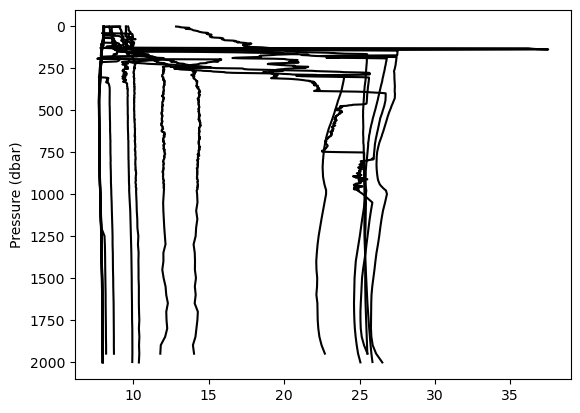

In [58]:
plt.figure()

for p in range(0, len(argo_n['N_PROF'])):
    profile_pressure = argo_n['PRES_ADJUSTED'].isel(N_PROF=p).values
    profile_data = argo_n['PH_IN_SITU_TOTAL_ADJUSTED'].isel(N_PROF=p).values
    plt.plot(profile_data[~np.isnan(profile_data)]+(p-1)*np.nanmean(profile_data)/10, 
         profile_pressure[~np.isnan(profile_data)], c='black')


plt.gca().invert_yaxis()
#plt.xlabel('Nitrate (µmol/kg)')
plt.ylabel('Pressure (dbar)')

In [59]:
# check original sprof file
argo_sprof_n = xr.load_dataset(argo_path+'1902382_Sprof.nc')


In [68]:
argo_sprof_n

<xarray.Dataset>
Dimensions:                          (N_PROF: 23, N_PARAM: 9, N_CALIB: 1,
                                      N_LEVELS: 527)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/93)
    DATA_TYPE                        object b'Argo synthetic profile          '
    FORMAT_VERSION                   object b'1.0 '
    HANDBOOK_VERSION                 object b'1.2 '
    REFERENCE_DATE_TIME              object b'19500101000000'
    DATE_CREATION                    object b'20220825072049'
    DATE_UPDATE                      object b'20220825072049'
    ...                               ...
    NITRATE                          (N_PROF, N_LEVELS) float32 nan nan ... nan
    NITRATE_QC                       (N_PROF, N_LEVELS) object nan nan ... nan
    NITRATE_dPRES                    (N_PROF, N_LEVELS) float32 nan nan ... nan
    NITRATE_ADJUSTED                 (N_PROF, N_LEVELS) float32 nan nan ... nan
    NITRATE_ADJUSTED_QC              (N_PROF, N_LEVELS) object nan nan ... nan
    NITRATE_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 nan nan ... nan
Attributes:
    title:                Argo float vertical profile
    institution:          AOML
    source:               Argo float
    history:              2022-08-25T07:20:49Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.13 (version 09.06.2022 for ARGO_simplified_profile)

In [61]:
# Function to convert an array from NumPy datetime64 to Python float format
def datetime_to_float(dt):
  return (dt - np.datetime64('1900-01-01')) / np.timedelta64(1,'D')

# Function to convert an array from Python float to NumPy datetime64 format
def float_to_datetime(nums):
  return (nums * np.timedelta64(1,'D')) + np.datetime64('1900-01-01')

# Function to interpolate data from a specified float parameter to a uniform time and pressure grid
def interpolate_depth_section(param_name,specify_qc_flags=None,pres_interval=1.0):
  """
  Arguments:
      param_name: string with netCDF file parameter name (e.g., 'TEMP_ADJUSTED') to interpolate
      specify_qc_flags: None to ignore QC flags
                        or a list of QC flags (e.g., [1,2,3]) indicating which data to retain before interpolation
      pres_interval: vertical resolution for interpolating pressure (z) axis (default: 1.0 dbar)
  
  Returns:
      time_coord: 1-D NumPy array with original profile timestamps in np.datetime64 format
      pres_coord: 1-D NumPy array with a uniform pressure (z) coordinate from 0 dbar to the deepest recorded
                  pressure value, at a resolution of  dbar
      time_grid: 2-D NumPy array with the meshed grid of time_coord
      pres_grid: 2-D NumPy array with the meshed grid of pres_coord
      param_gridded: 2-D NumPy array with the interpolated parameter values at the locations of time_grid and pres_grid

  """

  # New grid points
  time_coord = data['JULD'].values
  pres_coord = np.arange(0,data['PRES'].max(),pres_interval)
  time_grid, pres_grid = np.meshgrid(time_coord,pres_coord)
  time_grid = datetime_to_float(time_grid)     # Convert from np.datetime64 to float

  # 1-D (flattened) versions of old grids and parameter values
  time_1D = np.tile(data['JULD'].values,(len(data['N_LEVELS']),1)).T.flatten()
  pres_1D = data['PRES'].values.flatten()
  param_1D = data[param_name].values.flatten()
  if param_1D.dtype == object:         # If parameter is an array of QC flag data
    param_1D = param_1D.astype(float)  # Convert QC flags from dtype 'object' to float
    interp_method = 'nearest'          # Use nearest-neighbor interpolation for QC flags to avoid unwanted averaging
  else:
    interp_method = 'linear'           # Use bilinear interpolation for normal data fields

  # Extract only values matching specified QC flags
  if specify_qc_flags is not None:
    qc_1D = data[param_name + '_QC'].values.astype(float).flatten()
    qc_mask = np.tile(False,len(qc_1D))
    for qc_flag in specify_qc_flags:
      qc_mask = np.logical_or(qc_mask,qc_1D == qc_flag)
    time_1D = time_1D[qc_mask]
    pres_1D = pres_1D[qc_mask]
    param_1D = param_1D[qc_mask]

  # Remove NaN values before interpolation
  time_1D = datetime_to_float(time_1D[~np.isnan(param_1D)])       # Convert from np.datetime64 to float
  pres_1D = pres_1D[~np.isnan(param_1D)]
  param_1D = param_1D[~np.isnan(param_1D)]

  # Interpolate from irregular points to grid
  param_gridded = interpolate.griddata((time_1D,pres_1D),param_1D,(time_grid,pres_grid),method=interp_method)

  # Return coordinates, grid, and gridded data
  return time_coord, pres_coord, float_to_datetime(time_grid), pres_grid, param_gridded

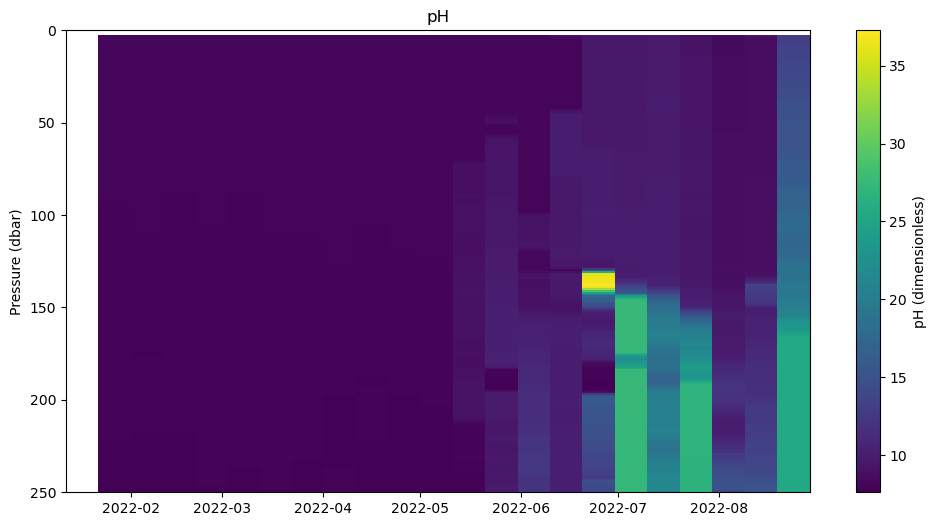

In [71]:
data = argo_sprof_n
# Interpolate data
param_name = 'PH_IN_SITU_TOTAL_ADJUSTED'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar(label='{0} ({1})'.format(data[param_name].long_name,data[param_name].units))
plt.title(data[param_name].long_name);

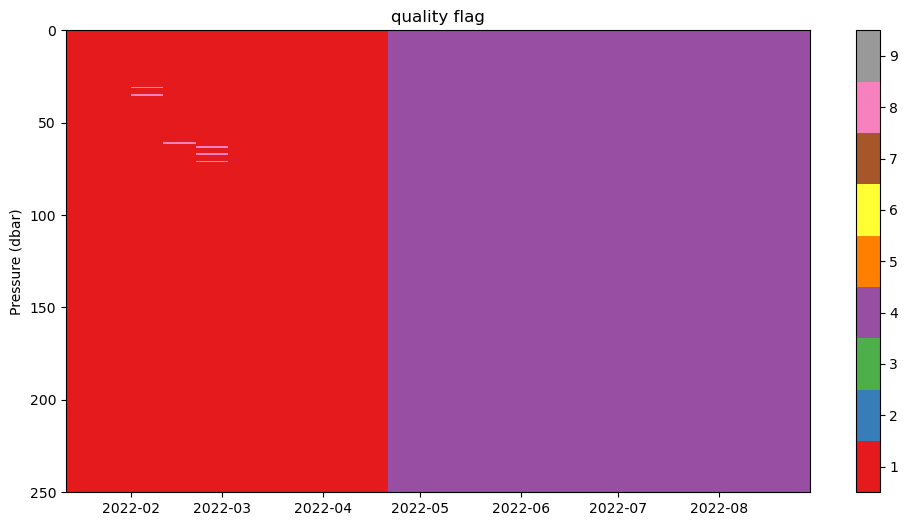

In [72]:


# Interpolate data
param_name = 'PH_IN_SITU_TOTAL_ADJUSTED_QC'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded,cmap='Set1',vmin=0.5,vmax=9.5)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar()
plt.title(data[param_name].long_name);
     


In [231]:
# plotting pCO2 impacts for floats:
derivedlist = []
for file in os.listdir(argo_path + 'derived/'):
    if file.endswith('derived_3.nc'):
        derivedlist.append(file)

In [253]:
pCO2_impact_np = np.array(pCO2_impact)
o2_offset_3 = np.array(o2_offset_3)


In [252]:

msk = (pCO2_impact_np>-300) & (pCO2_impact_np<300)
pCO2_impact_np[msk]

array([-3.04727440e+00, -3.83206054e-01, -5.46419146e+01, -3.80179886e+00,
       -6.73134577e+00,  1.80728654e-01, -5.07942703e+00, -7.11855753e+00,
       -5.11872898e-01, -9.15152629e-01, -1.23190152e+00, -2.83042746e-01,
       -4.04903219e+00, -6.73877186e+00, -8.90506718e+00, -1.59923966e+00,
       -3.32092430e+00, -2.49203725e+00, -1.18092331e+00, -1.75150784e+01,
        1.16684480e+00, -9.77166874e+00, -2.34527392e+00, -3.49790402e+00,
       -7.43815923e-01, -8.04351215e-01, -4.78391012e+00,  7.17508124e-01,
       -5.48601940e+00, -1.16150189e+01, -6.37980012e+00, -4.26965598e+00,
       -2.58096034e+00, -1.10878719e+00, -1.36361777e+00, -1.12703677e+01,
       -1.54518720e+00, -2.03598953e+00, -2.23367891e+00, -6.60109538e-01,
       -5.95943023e+00, -4.10000985e+00, -5.51171985e+00, -1.23151781e+00,
       -1.75379702e+01, -3.11064750e+00, -6.07226860e-03, -9.92924105e-01,
       -1.21677547e+00, -7.47437271e+00, -2.46570962e+00,  1.29542099e-01,
       -3.20297207e-01,  

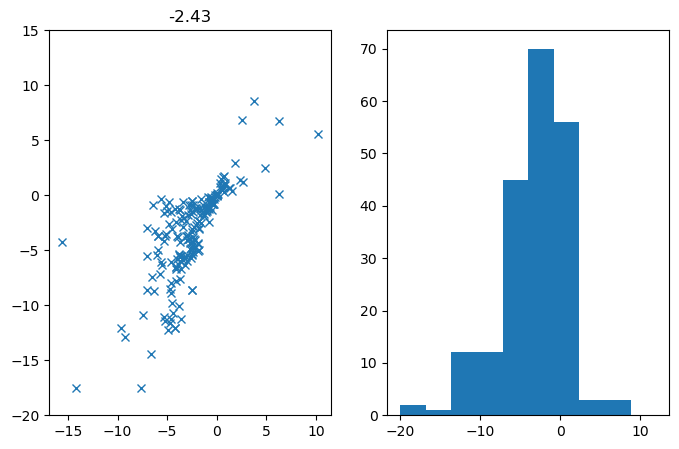

In [274]:
plt.figure(figsize=(8,5))

plt.subplot(121)
plt.plot(o2_offset_3[msk], pCO2_impact_np[msk], marker = 'x', linestyle='None')
plt.ylim(-20,15)
plt.title("%.2f" % np.nanmedian(pCO2_impact_np))

plt.subplot(122)
plt.hist(pCO2_impact_np[msk], range=[-20, 12])

plt.savefig(output_dir_figs + 'float_pCO2_impact.png')


In [10]:
print(np.mean(glodap_offsets.DOXY_ADJUSTED_offset))
print(np.nanmedian(glodap_offsets.DOXY_ADJUSTED_offset))

plt.figure(figsize=(20,12))
plt.hist(glodap_offsets.DOXY_ADJUSTED_offset, bins=np.linspace(-400, 400, 401))

plt.xlabel('DOXY Offset')
plt.savefig(output_dir_figs + 'Glodap_offsets_doxy_plus_minus_400.png')


NameError: name 'glodap_offsets' is not defined

Looking at impact of oxygen offsets on pH / pCO2 / Nitrate / DIC

In [4]:
# load glodap_offsets with cal info:

glodap_offsets = xr.load_dataset(output_dir+'glodap_offsets_withcalibration.nc')

In [5]:
#create meta groups based on calibration groups (air cal, no air cal, no cal)
g = glodap_offsets.o2_calib_group.copy(deep=True)
g = g.where(glodap_offsets.o2_calib_group == 'air cal','not air')
glodap_offsets['o2_calib_air'] = xr.where(glodap_offsets.o2_calib_group=='bad','no cal',g)

glodap_offsets['o2_calib_air_key'] = xr.where(glodap_offsets.o2_calib_air=='air cal',1,0)

glodap_offsets['o2_not_air_key'] = xr.where(glodap_offsets.o2_calib_air=='not air',-1,0)
glodap_offsets['o2_cal_key'] = glodap_offsets['o2_calib_air_key'] + glodap_offsets['o2_not_air_key']

wmo_means = glodap_offsets.groupby('main_float_wmo').mean(...)

In [6]:
# new dataset of air_cal floats only
a = wmo_means.where(wmo_means.o2_cal_key>0.6, drop=True)

In [55]:
# checking for inconsistencies in interpolated vs. derived lengths

pH_count = 0;
# load float files, use offset information to calculate impact 
for n in range(2,3): #range(0, len(a.main_float_wmo)):
    wmo_n = int(a.main_float_wmo[n].values)
    
    argo_derived_n = xr.load_dataset(argo_path+ 'derived/' + str(wmo_n) + '_derived.nc')

    print(str(n) + ': ' + str(a.main_float_wmo[n].values))

    print(argo_wmo[wmo_n].PRES_ADJUSTED.shape)
    print(argo_derived_n.PRES_ADJUSTED.shape)
    print(' ')
    

2: 1901362
(36, 951)
(18, 78)
 


In [64]:
argo_derived_n.PRES_ADJUSTED[0,:]

<xarray.DataArray 'PRES_ADJUSTED' (N_LEVELS: 78)>
array([   6.7     ,   10.9     ,   15.9     ,   21.1     ,   25.900002,
         30.900002,   35.3     ,   40.7     ,   45.4     ,   50.4     ,
         60.3     ,   70.2     ,   80.2     ,   90.299995,  100.7     ,
        110.6     ,  120.2     ,  129.9     ,  140.      ,  150.5     ,
        189.59999 ,  200.8     ,  210.3     ,  220.5     ,  230.4     ,
        240.8     ,  250.09999 ,  260.      ,  270.      ,  280.6     ,
        290.7     ,  300.2     ,  310.6     ,  320.2     ,  330.      ,
        340.      ,  350.40002 ,  374.90002 ,  400.7     ,  425.30002 ,
        450.5     ,  475.      ,  500.6     ,  524.9     ,  550.      ,
        575.2     ,  600.5     ,  625.3     ,  650.3     ,  674.9     ,
        700.3     ,  750.8     ,  800.60004 ,  849.8     ,  900.10004 ,
        950.2     , 1000.60004 , 1049.7     , 1099.5     , 1150.      ,
       1200.      , 1250.7999  , 1300.      , 1349.8999  , 1400.      ,
       1450.2999  , 1500.2999  , 1549.8999  , 1600.1     , 1650.2     ,
       1700.2999  , 1750.3999  , 1800.3999  , 1850.2     , 1900.3999  ,
       1950.1     ,         nan,         nan], dtype=float32)
Dimensions without coordinates: N_LEVELS

In [62]:
argo_wmo[wmo_n].TEMP_ADJUSTED[:,0]

<xarray.DataArray 'TEMP_ADJUSTED' (N_PROF: 36)>
array([5.958705, 6.061573, 5.986551, 6.152714, 5.939236, 6.016245, 6.049644,
       6.164514, 6.204602, 6.236   , 6.153162, 6.296157, 6.23022 , 6.24085 ,
       6.243927, 6.233834, 6.328376, 6.32239 , 5.958705, 6.061573, 5.986551,
       6.152714, 5.939236, 6.016245, 6.049644, 6.164514, 6.204602, 6.236   ,
       6.153162, 6.296157, 6.23022 , 6.24085 , 6.243927, 6.233834, 6.328376,
       6.32239 ])
Dimensions without coordinates: N_PROF

In [45]:
LIPHR_path = liar_dir

pH_count = 0;
# load float files, use offset information to calculate impact 
for n in range(37,38): #range(0, len(a.main_float_wmo)):
    wmo_n = int(a.main_float_wmo[n].values)
    
    argo_derived_n = xr.load_dataset(argo_path+ 'derived/' + str(wmo_n) + '_derived.nc')

    # check if the float also has pH
    if 'PH_IN_SITU_TOTAL_ADJUSTED' in argo_derived_n.keys() and np.any(~np.isnan(argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED)):
        pH_count = pH_count+1
        print(str(n) + ': ' + str(a.main_float_wmo[n].values))

    else:
        continue
    
    nprof = argo_derived_n.LATITUDE.shape[0]

    #test_pH = np.empty(nprof, dtype=float)
    
    # initialize coordinate and measurement arrays
    Coordinates_all = np.empty([nprof, 3],dtype=float)
    Coordinates_all[:] = np.nan
       
    Measurements_all = np.empty([nprof, 4],dtype=float)
    Measurements_all[:] = np.nan
    
    MeasIDVec = [1, 7, 3, 6]
    for p in range(nprof):
        index_1500 = argo_wmo[wmo_n].PRES_ADJUSTED[p,:]==1500

        #argo_wmo[5904659].PSAL_ADJUSTED[0,index_1500]
        Coordinates_all[p,:] = np.stack((argo_wmo[wmo_n].LONGITUDE[p].values.flatten(), 
                            argo_wmo[wmo_n].LATITUDE[p].values.flatten(), 
                            argo_wmo[wmo_n].PRES_ADJUSTED[p,index_1500].values.flatten()),
                            axis=1)
        Measurements_all[p,:] = np.stack((argo_wmo[wmo_n].PSAL_ADJUSTED[p,index_1500].values.flatten(), 
                             argo_wmo[wmo_n].TEMP_ADJUSTED[p,index_1500].values.flatten(), 
                             argo_wmo[wmo_n].NITRATE_ADJUSTED[p,index_1500].values.flatten(), 
                             argo_wmo[wmo_n].DOXY_ADJUSTED[p,index_1500].values.flatten()),
                             axis=1)
    
    
    # calculate LIPHR pH for all profiles
    test_pH = carbon_utils.LIPHR_matlab(LIPHR_path,
                                    Coordinates_all.tolist(),
                                    Measurements_all.tolist(),
                                    MeasIDVec, 
                                    OAAdjustTF = False)  
       
    Measurements_o2_offset = np.concatenate(([Measurements_all[:,0]], 
                                  [Measurements_all[:,1]],
                                  [Measurements_all[:,2]],
                                  [Measurements_all[:,3]] + a.DOXY_ADJUSTED_offset[n].values))
    Measurements_o2_offset = np.transpose(Measurements_o2_offset)
    # calculate LIPHR pH for all profiles
    new_pH = carbon_utils.LIPHR_matlab(LIPHR_path,
                                    Coordinates_all.tolist(),
                                    Measurements_o2_offset.tolist(),
                                    MeasIDVec, 
                                    OAAdjustTF = False)  
    argo_derived_n['pH_orig_LIPHR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
    argo_derived_n.pH_orig_LIPHR[:] = test_pH[:,0]

    argo_derived_n['pH_O2_ADJUST_LIPHR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
    argo_derived_n.pH_O2_ADJUST_LIPHR[:] = new_pH[:,0]
    # difference between pH_O2_orig_LIPHR and PH_IN_SITU_TOTAL_ADJUSTED- should that average 0? 
    # Impact of O2 can be seen in the test_pH minus new_pH average 
    
    argo_derived_n['PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET'] = \
        argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.mean(new_pH - test_pH)
    
    argo_derived_n.to_netcdf(argo_path+ 'derived/' + str(wmo_n) + '_derived_2.nc')


37: 5904659


In [46]:
argo_wmo[5904659]

<xarray.Dataset>
Dimensions:                    (N_PROF: 153, N_LEVELS: 951)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/20)
    wmo                        (N_PROF) int64 5904659 5904659 ... 5904659
    profile                    (N_PROF) float64 ...
    juld                       (N_PROF) datetime64[ns] ...
    LATITUDE                   (N_PROF) float64 ...
    LONGITUDE                  (N_PROF) float64 ...
    num_var                    (N_PROF) float64 ...
    ...                         ...
    spice                      (N_PROF, N_LEVELS) float64 ...
    PRES_ADJUSTED              (N_PROF, N_LEVELS) float64 ...
    DIC                        (N_PROF, N_LEVELS) float64 ...
    TALK_LIAR                  (N_PROF, N_LEVELS) float64 ...
    pCO2                       (N_PROF, N_LEVELS) float64 ...
    pCO2_pH_corr               (N_PROF, N_LEVELS) float64 ...

In [47]:
argo_derived_n

        #call CO2sys to calculate pCO2 with bias correction and no O2 correction (check against original)
        results = pyco2.sys(
                par1=argo_derived_n.TALK_LIAR, 
                par2=argo_derived_n.pH_insitu_corr,
                par1_type=1,
                par2_type=3,
                temperature=argo_n.TEMP_ADJUSTED, 
                pressure=argo_n.PRES_ADJUSTED, 
                salinity=argo_n.PSAL_ADJUSTED, 
                temperature_out=25.* np.ones(argo_n.PRES_ADJUSTED.shape), #fixed 25C temperature
                pressure_out=argo_n.PRES_ADJUSTED,
                total_silicate=SI,
                total_phosphate=PO4,
                opt_pH_scale = 1, #total
                opt_k_carbonic=10, #Lueker et al. 2000
                opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
                opt_total_borate=2, # Lee et al. 2010
                opt_k_fluoride=2, # Perez and Fraga 1987
                opt_buffers_mode=1,
                )

<xarray.Dataset>
Dimensions:                                       (N_PROF: 153, N_LEVELS: 558)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/22)
    wmo                                           int64 5904659
    CYCLE_NUMBER                                  (N_PROF) float64 1.0 ... 153.0
    LONGITUDE                                     (N_PROF) float64 -55.38 ......
    LATITUDE                                      (N_PROF) float64 -59.64 ......
    JULD_LOCATION                                 (N_PROF) datetime64[ns] 201...
    TEMP_ADJUSTED                                 (N_PROF, N_LEVELS) float32 ...
    ...                                            ...
    TALK_LIAR                                     (N_PROF, N_LEVELS) float64 ...
    pCO2                                          (N_PROF, N_LEVELS) float64 ...
    pCO2_pH_corr                                  (N_PROF, N_LEVELS) float64 ...
    pH_orig_LIPHR                                 (N_PROF) float64 7.88 ... 7...
    pH_O2_ADJUST_LIPHR                            (N_PROF) float64 7.875 ... ...
    PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET  (N_PROF, N_LEVELS) float32 ...

-0.0036396733963356244

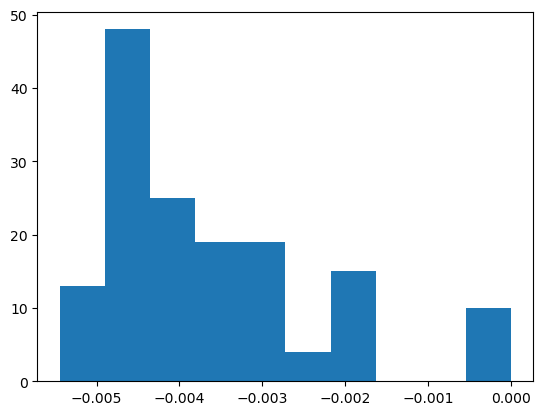

In [209]:
test_pH - new_pH
plt.hist(new_pH - test_pH)
np.mean(new_pH - test_pH)

<xarray.DataArray 'PH_IN_SITU_TOTAL_ADJUSTED' ()>
array(0.00315701)

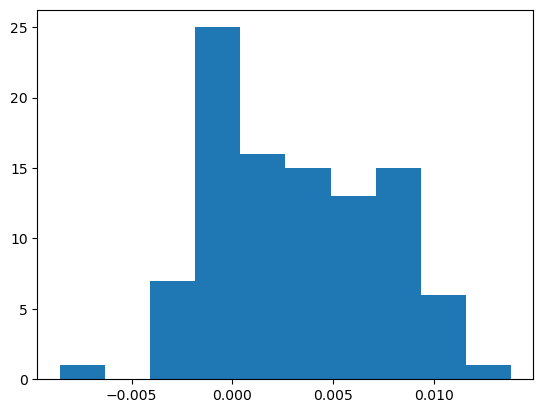

In [154]:
plt.hist(argo_wmo[wmo_n].PH_IN_SITU_TOTAL_ADJUSTED[:,index_1500] - test_pH)
np.mean(argo_wmo[wmo_n].PH_IN_SITU_TOTAL_ADJUSTED[:,index_1500] - test_pH)